In [45]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

from glob import glob
from PIL import Image
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, GlobalAveragePooling2D, Dense, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import visualkeras

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

from tensorflow.keras.applications import VGG19


In [21]:
#! pip install visualkeras

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:

data_directory = 'drive/MyDrive/Colab Notebooks/kvasir'

In [24]:
# Example usage
#data_directory = '../kvasir-dataset'
batch_size = 20
image_size = (100,100)

# Image Enhancement

Apply a series of image processing techniques to improve the visual quality of an input image.

**CLAHE** improves contrast locally without amplifying noise too much.

**Gaussian blur** smoothens the image to reduce noise that could be present after contrast enhancement.
The input image is converted to grayscale for the CLAHE step but is converted back to color (BGR) for further processing.

In [25]:
def enhance_image(img):
    # Convert image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(gray_img)

    # Convert back to BGR color space
    enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_GRAY2BGR)

    # Apply Gaussian Blur for noise reduction
    enhanced_img = cv2.GaussianBlur(enhanced_img, (5, 5), 0)

    return enhanced_img


#  Segmentation

In [26]:
def apply_threshold(img):
    # Convert image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a binary threshold
    _, thresh_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)

    return thresh_img

def preprocess_image(file_path, image_size=image_size):
    img = cv2.imread(file_path).astype(np.uint8)
    img_enhanced = enhance_image(img)
    img_resized = cv2.resize(img_enhanced,  image_size[:2])
    img_normalized = img_resized / 255.0
    thresh_img = apply_threshold(img_resized)
    return img_normalized, thresh_img


def preprocess_labels(labels, image_size=image_size):
    masks = np.zeros((len(labels), image_size[0], image_size[1], 1), dtype=np.uint8)
    for i, label in enumerate(labels):
        masks[i] = np.expand_dims(np.where(label == 1, 1, 0), axis=-1)
    return masks


# Loading Images in Chunks

In [27]:

def load_images_in_chunks(data_directory, batch_size, image_size=image_size):
    classes = os.listdir(data_directory)
    if '.ipynb_checkpoints' in classes:
      classes.remove('.ipynb_checkpoints')
    file_paths = []
    labels = []
    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(data_directory, class_name)
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file_name))
            labels.append(class_index)

    print(classes)
    print (np.unique(labels))
    data = list(zip(file_paths, labels))
    np.random.shuffle(data)
    file_paths, labels = zip(*data)

    for i in range(0, len(file_paths), batch_size):
        batch_files = file_paths[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]
        batch_images = [preprocess_image(file, image_size) for file in batch_files]
        # Separate the images and thresholds
        batch_images, batch_thresholds = zip(*batch_images)
        batch_images = np.array(batch_images)
        batch_thresholds = np.array(batch_thresholds)
        batch_labels = np.array(batch_labels)
        #batch_labels = preprocess_labels(np.array(batch_labels), image_size)
        yield batch_images, batch_thresholds, batch_labels


# Initialize lists to store all chunks
all_images = []
all_thresholds = []
all_labels = []

# Iterate through each chunk of images, thresholds, and labels
iter = 1
for images, thresholds, labels in load_images_in_chunks(data_directory, batch_size):
    print(iter, ')   :  ',images.shape, thresholds.shape , labels.shape )



    # Append each chunk to the respective list
    all_images.append(images)
    all_thresholds.append(thresholds)
    all_labels.append(labels)

    if iter == 100:
      break
    else:
      iter +=1
# After the loop, concatenate all chunks along the first axis
images = np.concatenate(all_images, axis=0)
thresholds = np.concatenate(all_thresholds, axis=0)
labels = np.concatenate(all_labels, axis=0)

#combine arrays for images, thresholds, and labels
print('total data: ', images.shape, thresholds.shape, labels.shape)

['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'ulcerative-colitis', 'polyps']
[0 1 2 3 4 5 6 7]
1 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
2 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
3 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
4 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
5 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
6 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
7 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
8 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
9 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
10 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
11 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
12 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
13 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
14 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
15 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
16 )   :   (20, 100, 100, 3) (20, 100, 100) (20,)
17 )   :   (20, 100, 100, 3) (20, 100, 100) 

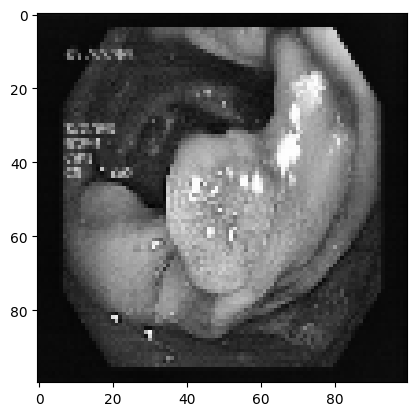

In [28]:
image = (images[0] * 255).astype(np.uint8)
converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(converted_image )
#plt.imshow(thresholds[0], 'gray' )


###  Displaying images for each category

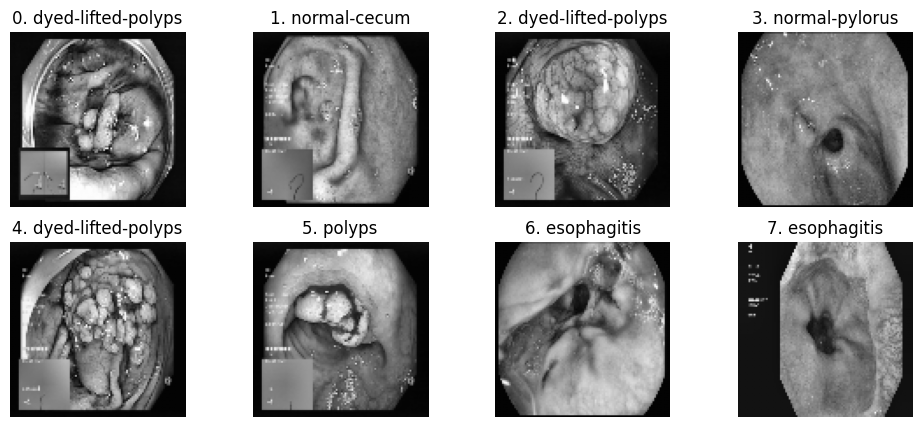

In [29]:
categories = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'ulcerative-colitis', 'polyps']  # set labels


plt.figure(figsize=(12, 5))
st, end = 0, 250
for i in range(len(categories)):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 250
    plt.imshow(images[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[labels[idx]]}")
    plt.axis("off")
plt.show()

# Train and Evaluate the Model

### Define VGG19 Architecture

In [37]:

def vgg19_model(input_size=(100, 100, 3), num_classes=8):
    # Load VGG19 with pre-trained ImageNet weights, excluding the top layers
    if os.path.isfile("vgg19_model.h5"):
    # load model
      base_model = load_model("vgg19_model.h5")
    else:
      base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_size)

    # Freeze the layers of VGG19 to retain the pre-trained weights
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    #x = GlobalAveragePooling2D()(x)  # Global average pooling
    x = Flatten()(x)
    #x = Dropout(0.5)(x)  # Dropout for regularization
    #x = Dense(1024, activation='relu')(x)
    #x = Dropout(0.5)(x)  # Dropout for regularization
    #-----
    #x = Dense(512, activation='relu')(x)
    #x = Dropout(0.5)(x)  # Dropout for regularization

    #x = Dense(512, activation='relu')(x)
    #x = Dropout(0.3)(x)  # Dropout for regularization

   # x = Dense(128, activation='relu')(x)
    #x = Dropout(0.3)(x)  # Dropout for regularization
    #---------
    outputs = Dense(num_classes, activation='softmax')(x)  # Final output layer for 8 classes

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)

    return model

### Compile the Model

In [38]:

from tensorflow.keras.optimizers import SGD, Adam

#model = unet_model()
model = vgg19_model()
#model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
sgd = SGD(learning_rate=1e-3, momentum=0.9, nesterov=False)

model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])


In [39]:
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,061,256 (76.53 MB)

 Trainable params: 36,872 (144.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

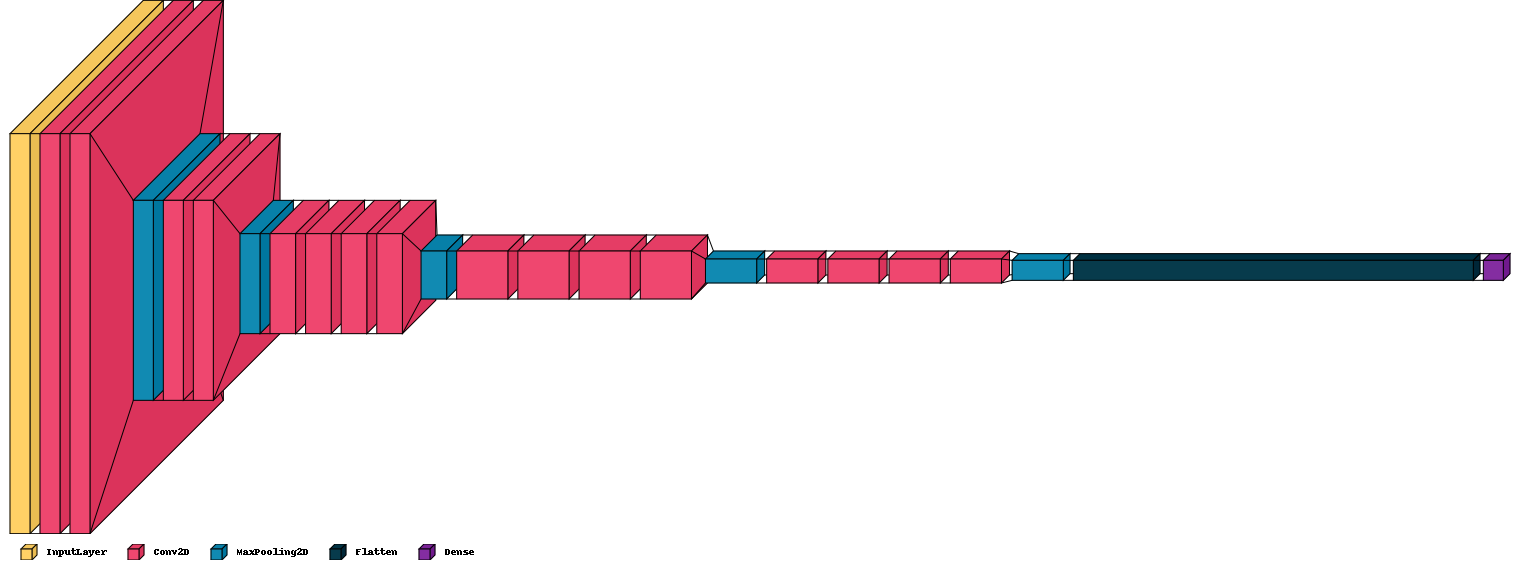

In [40]:
visualkeras.layered_view(model,legend = True)

### Prepare the Data

In [41]:


X_train, X_test, y_train, y_test = train_test_split(images,labels, test_size = .2, random_state = 42)
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)
# Check data types and shapes
print(f'X_train type: {type(X_train)}, shape: {X_train.shape}')
print(f'y_train type: {type(y_train)}, shape: {y_train.shape}')
print(f'X_test type: {type(X_test)}, shape: {X_test.shape}')
print(f'y_test type: {type(y_test)}, shape: {y_test.shape}')

X_train type: <class 'numpy.ndarray'>, shape: (1600, 100, 100, 3)
y_train type: <class 'numpy.ndarray'>, shape: (1600, 8)
X_test type: <class 'numpy.ndarray'>, shape: (400, 100, 100, 3)
y_test type: <class 'numpy.ndarray'>, shape: (400, 8)


### Train the Model

In [42]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
print(np.isnan(X_test).sum(), np.isnan(y_test).sum())

0 0
0 0


In [44]:

es = EarlyStopping(
    patience = 5,
    restore_best_weights=True
)


try:
    history = model.fit(
        X_train, y_train,
        validation_split=.2,
        epochs=100,
        batch_size=16,
        verbose=1,
        callbacks = [es]
    )
except Exception as e:
    print(f"Error during model fitting: {e}")

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 284s 4s/step - accuracy: 0.2898 - loss: 1.8677 - val_accuracy: 0.4187 - val_loss: 1.3611
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.5759 - loss: 1.1741 - val_accuracy: 0.5813 - val_loss: 1.0610
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.6207 - loss: 1.0347 - val_accuracy: 0.5094 - val_loss: 1.1342
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.6315 - loss: 0.9479 - val_accuracy: 0.6625 - val_loss: 0.9702
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 297s 4s/step - accuracy: 0.6304 - loss: 0.9319 - val_accuracy: 0.5562 - val_loss: 1.1034
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy: 0.6890 - loss: 0.8164 - val_accuracy: 0.6500 - val_loss: 0.9486
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.7634 - loss: 0.7160 - val_accuracy: 0.6750 - val_loss: 0.8616
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.7285 - loss: 0.7772 - val_accuracy: 0.

### Evaluate and Save the Model

In [46]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Generate a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS

# Construct the filename with the timestamp
model_filename = f'drive/MyDrive/vgg19_model_{timestamp}.h5'

# Save the model with the timestamped filename
model.save(model_filename)

print(f"Model saved as {model_filename}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - accuracy: 0.7349 - loss: 0.7019


Test Loss: 0.7778944373130798
Test Accuracy: 0.7024999856948853
Model saved as drive/MyDrive/vgg19_model_20240905_140342.h5


In [47]:
unique_values = np.unique(labels)
num_unique_values = unique_values.size

print(f"the unique values in y_test: {unique_values}")
print(f"Number of unique values in y_test: {num_unique_values}")

the unique values in y_test: [0 1 2 3 4 5 6 7]
Number of unique values in y_test: 8


In [48]:
y_pred = model.predict(X_test)
#y_pred_classes = (y_pred > 0.5).astype(int)


13/13 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step


In [49]:
y_test.shape

(400, 8)

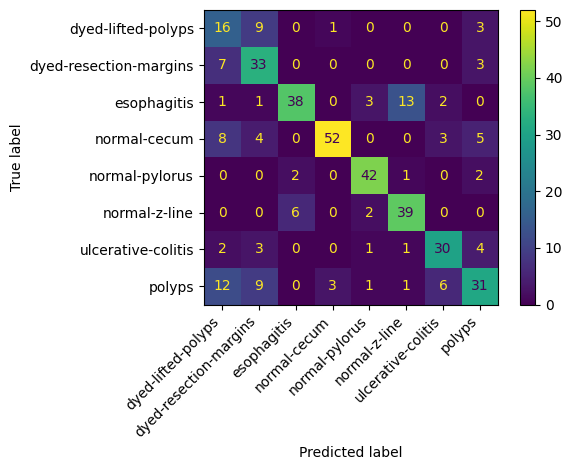

In [50]:
# Convert the continuous outputs to class labels by taking the argmax along the last axis
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure y_test is in the same format (as integer class labels)
y_test_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_pred_classes, y_test_classes)

# Visualize confusion matrix
categories = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'ulcerative-colitis', 'polyps']  # set labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to make room for the rotated labels
plt.tight_layout()

# Show the plot
plt.show()

In [51]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.55      0.35      0.43        46
           1       0.77      0.56      0.65        59
           2       0.66      0.83      0.73        46
           3       0.72      0.93      0.81        56
           4       0.89      0.86      0.88        49
           5       0.83      0.71      0.76        55
           6       0.73      0.73      0.73        41
           7       0.49      0.65      0.56        48

    accuracy                           0.70       400
   macro avg       0.71      0.70      0.69       400
weighted avg       0.71      0.70      0.70       400



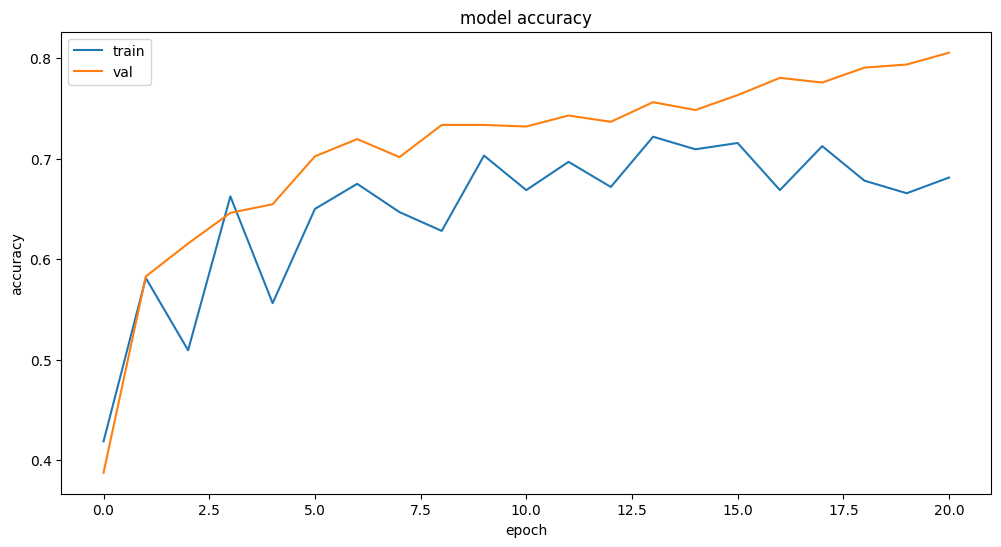

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:


# # Function to load a single image and preprocess it
# def preprocess_image(file_path, image_size=image_size):
#     img  = cv2.imread(file_path).astype(np.uint8)
#     img_resized = cv2.resize(img, image_size)
#     img_normalized = img_resized / 255.0
#     return img_normalized

# # Function to load images in chunks
# def load_images_in_chunks(data_directory, batch_size, image_size=image_size):
#     # Get the list of all files in the dataset
#     classes = os.listdir(data_directory)
#     file_paths = []
#     labels = []
#     for class_index, class_name in enumerate(classes):
#         class_dir = os.path.join(data_directory, class_name)
#         for file_name in os.listdir(class_dir):
#             file_paths.append(os.path.join(class_dir, file_name))
#             labels.append(class_index)

#     # Shuffle the file paths and labels
#     data = list(zip(file_paths, labels))
#     np.random.shuffle(data)
#     file_paths, labels = zip(*data)

#     # Load images in chunks
#     for i in range(0, len(file_paths), batch_size):
#         batch_files = file_paths[i:i + batch_size]
#         batch_labels = labels[i:i + batch_size]
#         #batch_images = [load_image(file, image_size) for file in batch_files]
#         batch_images = [preprocess_image(file, image_size) for file in batch_files]
#         batch_images = np.array(batch_images)
#         batch_labels = np.array(batch_labels)
#         yield batch_images, batch_labels



# for images, labels in load_images_in_chunks(data_directory, batch_size, image_size):
#     print(images.shape, labels.shape)
#     # Process your images and labels here
#     break  # Remove this break to process all batches